In [1]:
import os
import pickle
from tqdm import tqdm
import sentencepiece as spm

In [2]:
source_folder = '/scratche/home/apoorv/freebase'
! ls {source_folder}

aliases_from_webqsp_questions.txt
ComplexWebQuestions
create_half.ipynb
create_kg_filter_according_to_cohen_paper.ipynb
create_kg_for_t5_webqsp_qa.ipynb
create_subgraph_cmu_upto3.ipynb
create_subgraph_cwq.ipynb
create_subgraph.ipynb
create_t5_kg_only_named_entities.ipynb
cwq_all_ents.txt
cwq_all_rels.txt
cwq_create_final_kg.ipynb
cwq_ents_names_not_found.txt
cwq_full_name_triples.txt
cwq_full_new_fb_dump.txt
cwq_full.txt
cwq_get_entities_from_questions.ipynb
cwq_half.txt
cwq_kg_ents.txt
cwq_kg_full_correctfbdump.txt
cwq_kg_full_no_notable_for.txt
cwq_kg_full.txt
cwq_kg_full_with_names.txt
ent_identifiers_fbwq_full.pickle
ent_identifiers_fbwq_half_lego.pickle
ent_identifiers_fbwq_half.pickle
entities.dict
FB150k-50-webqsp.zip
fb2w.nt
fbwq_full_filtered_triples.txt
fbwq_half_filtered_triples.txt
fbwq_half_hongyu
fbwq_half_lego_entities_with_no_name.txt
fbwq_half_lego_filtered_triples.txt
fbwq_half_lego_processed
filtered_triples_final2.txt
filtered_triples_final.txt
filtered_triples_full

In [3]:
def readTriples(fname):
    f = open(fname)
    triples = []
    for line in f:
        if line[-1] == '\n':
            line = line[:-1]
        triples.append(line.split('\t'))
    f.close()
    return triples

def getEntities(triples):
    ents = set()
    for t in triples:
        ents.add(t[0])
        ents.add(t[2])
    return ents

def getRelations(triples):
    rels = set()
    for t in triples:
        rels.add(t[1])
    return rels


In [4]:
fname = os.path.join(source_folder, 'cwq_half.txt')
all_triples = readTriples(fname)

In [6]:
data = {}
num_valid = 5000
data['valid'] = all_triples[:num_valid].copy()
data['train'] = all_triples[num_valid:]
data['test'] = data['valid']

In [4]:
# load half data
# data = {}
# splits = ['train', 'test', 'valid']
# for split in splits:
#     fname = os.path.join(source_folder, split + '.txt')
#     data[split] = readTriples(fname)

In [8]:
splits = ['train', 'test', 'valid']
entities = set()
relations = set()
for split in splits:
    e = getEntities(data[split])
    entities = entities.union(e)
    r = getRelations(data[split])
    relations = relations.union(r)
len(entities), len(relations)

(4370180, 359)

In [9]:
data['train'][5000]

['m.06gsl8', 'broadcast.broadcast.area_served', 'm.01_d4']

In [11]:
len(data['train'])

6897740

In [12]:
from unidecode import unidecode
# lowering everything

def normalizeRelation(rel):
#     rel = rel.replace('_', ' ')
    rel = unidecode(rel)
    rel = rel.split('.')[-1]
    rel = rel.replace('_', ' ')
    rel = rel.replace('|', ',')
    rel = rel.lower()
    return rel

def normalizeEntity(ent):
    ent = unidecode(ent)
    ent = ent.replace('|', '')
    ent = ent.lower()
    return ent


def getBestName(names, max_words = 5):
    best_name = names[0]
    for name in names:
        if name.endswith('@en'):
            best_name = name
    name = best_name.replace('"', '')
    name = name.split('@')[0]
    name = normalizeEntity(name)
#     name = name[:max_len]
    name = ' '.join(name.split()[:max_words])
    return name

def getBestDescription(descriptions, max_description_words=8):
    best_desc = descriptions[0]
    for desc in descriptions:
        if desc.endswith('@en'):
            best_desc = desc
    desc = best_desc
    desc = (''.join(desc.split('@')[:-1])).replace('"', '')
    desc = ' '.join(desc.split()[:max_description_words])
    # unidecode stuff
    desc = normalizeEntity(desc)
    return desc

def addDescriptionToName(name, desc):
    desc = desc.replace(name, 'it')
    desc = desc.replace('it is a ', '')
    desc = desc.replace('it was a ', '')
    desc = desc.replace('it was an ', '')
    desc = desc.replace('it is an ', '')
    desc = desc.replace('it is the ', '')
    desc = desc.replace('it was the ', '')
    desc = desc.replace('.', '')
    name = name + ' (' + desc + ')'
    return name

def truncateWords(name, num_words):
    name = name.split()[:num_words]
    name = ' '.join(name)
    return name

In [16]:
# import pickle
# from tqdm import tqdm
# aliases_dict = {}
# count = 0
# fname = '/scratche/home/apoorv/freebase/ent_identifiers_fbwq_half_lego.pickle'
# x = pickle.load(open(fname, 'rb'))
# descriptions = {}
def readTriples(fname):
    f = open(fname, 'r')
    lines = []
    for line in f:
        line = line.strip().split('\t')
        lines.append(line[:3])
    f.close()
    return lines

fname = os.path.join(source_folder, 'cwq_full_name_triples.txt')
name_triples = readTriples(fname)

In [17]:
from collections import defaultdict

x = defaultdict(list)

def cleanEntity(s):
    ent = s[:-1].split('/')[-1]
    return ent

for t in tqdm(name_triples):
    e = cleanEntity(t[0])
    name = t[2]
    x[e].append(name)
    

100%|██████████████████████████████████████████████████| 15210643/15210643 [00:30<00:00, 498296.14it/s]


In [18]:
len(entities)

4370180

In [50]:
aliases_dict = {}
max_name_words = 12
for ent in tqdm(entities):
    if ent not in x:
        aliases_dict[ent] = getBestName([ent]) # to unidecode basically
        continue
    names = x[ent]
    name = getBestName(names, max_name_words)
    aliases_dict[ent] = name

100%|████████████████████████████████████████████████████| 4370180/4370180 [00:27<00:00, 161146.79it/s]


In [51]:
i = 0
count = 0
for k, v in aliases_dict.items():
    if (v.startswith('g.') or v.startswith('m.')) and ' ' not in v:
#         print(k, v)
        count += 1
#     if count > 100:
#         break
count

98

In [52]:
len(set(aliases_dict.values()))

3894066

In [53]:
import random
random.sample(list(aliases_dict.values()), 10)

['firebird suite (1919): 1. introduction',
 'gerry loose',
 'the key to astrology containing a complete system or genethliacal astrology',
 'san clemente apartments',
 'dejan despic',
 'brandon taylor',
 'michael fuchs',
 'daniel koch',
 'the words of the twelve prophets',
 'eric skeels']

In [54]:
import pickle
from unidecode import unidecode
relation_map = {}
fname = '/scratche/home/apoorv/freebase/relation_names_from_google_cwq.pickle'
relation_names_from_google = pickle.load(open(fname, 'rb'))
for rel in relations:
    rel_processed = relation_names_from_google[rel]
    rel_processed = unidecode(rel_processed)
    rel_processed = rel_processed.replace('|', ',')
    rel_processed = rel_processed.lower()
    if rel_processed == '':
        print(rel)
    relation_map[rel] = rel_processed

In [55]:
entity_map = {}
for ent in entities:
    val = aliases_dict[ent]
    if val.strip() == '':
        print('here', ent)
        val = ent
    entity_map[ent] = val

here m.011q6t0v
here m.0h1f4k_
here m.0244n04
here m.0h4yd4m
here m.010f5nm0
here m.04wcx76
here m.01pyww_
here m.010srk7b
here m.0681s06
here m.0wxs9_y
here m.010qnkd2
here m.03y9nr_


In [56]:
len(relation_map), len(set(relation_map.values()))

(359, 326)

In [57]:
len(entity_map), len(set(entity_map.values()))

(4370180, 3894077)

In [58]:
def mapTriple(triple, ent_map, rel_map):
    t = triple
    if t[0] not in ent_map or t[2] not in ent_map:
        print(t)
        return t
    
    new_triple = [ent_map[t[0]], rel_map[t[1]], ent_map[t[2]]]
    return new_triple

In [59]:
uniq_ent_map = entity_map

In [60]:
count = 0
for id in range(500):
    t = mapTriple(data['train'][id], uniq_ent_map, relation_map)
    if 'm.' in t[0] or 'm.' in t[2]:
        count += 1
        print(t)
count

['joseph m. proskauer', 'notable types', 'author']
['david m. brugge', 'gender', 'male']


2

In [61]:
import pickle
fname = '../freebase/cwq_aliases_from_questions.pickle'
cwq_aliases = pickle.load(open(fname, 'rb'))

In [65]:
# in cwq, in questions dataset, id<->string mapping is very bad
# for eg. china = belarus?
# so dont use it
count = 0
for key, value in cwq_aliases.items():
    if key in uniq_ent_map:
        val_from_map = uniq_ent_map[key]
        value = getBestName([value], max_name_words)
#         value = normalizeEntity(value)
        # TODO: we randomly chose 12 words? why 12?
#         value = truncateWords(value, 12)
        if value == '':
            value = key
        if value != val_from_map:
            count += 1
#             uniq_ent_map[key] = value
            print(key, '|', value, '|' ,val_from_map)
        
#             print(key, '*', value, '*', val_from_map)
count      

m.08dk0b | juice | gridlock'd
m.0160nk | emory university | tulane university
m.0574xy | tim kaine | jim webb
m.06mz5 | south pasadena | south dakota
m.0163v | china | belarus
m.0d05w3 | azerbaijan | china
m.0jhd | belarus | azerbaijan
m.0154j | cyprus | belgium
m.0j1z8 | turkey | united arab emirates
m.04sj3 | sierra leone | madagascar
m.05cb70 | nick cannon | reggie bush
m.053f8h | jim webb | tim kaine
m.02w9s | finland | faroe islands
m.0k6nt | austria | denmark
m.0k0y0 | brian mulroney | jean chretien
m.05cc1 | guinea | niger
m.01nqj | macau | cape verde
m.06mzp | belgium | switzerland
m.05qx1 | guatemala | panama
m.04g61 | liechtenstein | luxembourg
m.02qb83 | battle of la victoria | venezuelan war of independence
m.02qlx__ | dutch-venezuela war | battle of la victoria
m.02r0mx4 | 12th g-15 summit | machurucuto incident
m.02rf6lc | 2002 venezuelan coup d'etat attempt | 2007 rctv protests
m.0461c3 | venezuelan crisis of 1902-03 | 2002 venezuelan coup d'etat attempt
m.0c0349z | 2007

329

In [66]:
len(data['train'])

6897740

In [67]:
# save maps
import pickle
fname = 'data/fbwq_full/ent_map_cwq_half.pickle'
pickle.dump(uniq_ent_map, open(fname, 'wb'))
fname = 'data/fbwq_full/rel_map_cwq_half.pickle'
pickle.dump(relation_map, open(fname, 'wb'))

In [69]:
out_folder = '/scratche/home/apoorv/transformer-kgc/data/cwq_half'
splits = ['train', 'test', 'valid']

count = 0
for split in splits:
    fname = os.path.join(out_folder, split + '.txt')
    f = open(fname, 'w')
    triples = data[split]
    for t in triples:
        
        t = mapTriple(t, uniq_ent_map, relation_map)
        head, relation, tail = t
        
        # can we do with just predict tail?
        # since reverse relations might already be there
        # + the QA format is not going to be <topic entity> | qn
        # instead it will be regular question
        input = 'predict tail: {0} | {1} |'.format(head, relation)
        output = '{}'.format(tail)
        f.write(input + '\t' + output + '\n')
        
#         input = 'predict head: {0} | {1} |'.format(tail, relation)
#         output = '{}'.format(head)
#         f.write(input + '\t' + output + '\n')
    f.close()

In [108]:
count

0

In [70]:
# create entity_strings.txt which is needed in evaluation code
strings_file_name = 'entity_strings.txt'
f = open(os.path.join(out_folder, strings_file_name), 'w')
ents_uniq = set(uniq_ent_map.values())
for e in ents_uniq:
    f.write(e + '\n')
f.close()

In [110]:
# webqsp qa 
# def readQALines(fname):
#     f = open(fname)
#     questions = []
#     for line in f:
#         line = line.strip().split('\t')
#         q = line[0]
#         lhs = q.split('[')[0]
#         rhs = q.split(']')[1]
#         only_question = lhs + 'NE' + rhs
#         only_question = normalizeEntity(only_question)
# #         q = q.replace('[', '')
# #         q = q.replace(']', '')
# #         q = normalizeEntity(q)
#         questions.append(only_question)
#     return questions
        
# def writeLines(lines, fname):
#     f = open(fname, 'w')
#     for line in lines:
#         f.write(line + '\n')


In [111]:
for k, v in uniq_ent_map.items():
    if v == '':
        print(k, v)

'what character did natalie portman play in star wars NE'

In [81]:
# fname = 'data/MetaQA/full_qa.txt'
# questions = readQALines(fname)
# questions = list(set(questions))

In [82]:
# fname = 'data/MetaQA/only_questions_text.txt'
# writeLines(questions, fname)

In [124]:
vocab_size = 30000
sp = spm.SentencePieceTrainer.train(input='data/fbwq_half_lego/train.txt', 
                                    model_prefix='fbwq_half_lego_with_pad', vocab_size=vocab_size, 
                                    pad_id=3,
#                                     character_coverage=1.0,
#                                user_defined_symbols=['predict',
#                                                     'head',
#                                                     'tail',
#                                                     '|'],
#                                     normalization_rule_name='identity',
                              )

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: data/fbwq_half_lego/train.txt
  input_format: 
  model_prefix: fbwq_half_lego_with_pad
  model_type: UNIGRAM
  vocab_size: 30000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: 3
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
}
normalizer_spec {
  name: nmt_nfkc
  add_dummy_prefix: 1
  remove_extra_whitespaces: 1
  escape_whi

In [125]:
# sp = spm.SentencePieceProcessor(model_file='data/sentencepiece/metaqa_with_pad.model')
sp = spm.SentencePieceProcessor(model_file='fbwq_half_lego_with_pad.model')

In [114]:
# sp['Obama']

In [115]:
sp.decode(sp.encode('how old'))

'how old'

In [116]:
sp.encode('<pad>')

[4, 0, 1259, 57, 0]

In [195]:
sp['</s>']

2

In [117]:
sp.id_to_piece(3)

'<pad>'

In [122]:
lengths = []
count = 0
for e in tqdm(ents_uniq):
    encoded = sp.encode(e)
    l = len(encoded)
    if l > 500:
        print(e,l)
        l = 20
        count += 1
    lengths.append(l)
count

100%|██████████████████████████████████████████████████████| 149681/149681 [00:01<00:00, 123751.90it/s]


0

Text(0.5, 0, 'Tokenized lengths')

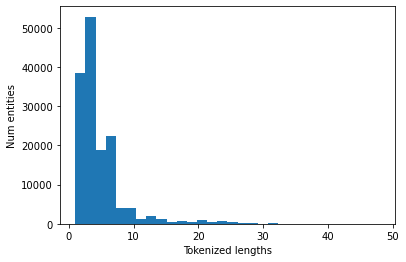

In [123]:
import matplotlib.pyplot as plt 

import numpy as np 

%matplotlib inline

# x = np.random.normal(size = 1000) 
x = lengths
plt.hist(x, bins=30) 

plt.ylabel('Num entities');
plt.xlabel('Tokenized lengths')

Text(0.5, 0, 'Tokenized lengths')

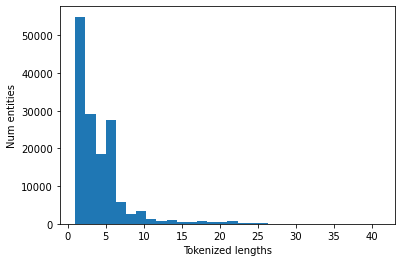

In [119]:
import matplotlib.pyplot as plt 

import numpy as np 

%matplotlib inline

# x = np.random.normal(size = 1000) 
x = lengths
plt.hist(x, bins=30) 

plt.ylabel('Num entities');
plt.xlabel('Tokenized lengths')

In [190]:
lengths = []
count = 0
for e in tqdm(relations):
    encoded = sp.encode(relation_map[e])
    l = len(encoded)
    if l > 10:
        print(relation_map[e])
        count +=1
    lengths.append(l)
count

100%|██████████| 1068/1068 [00:00<00:00, 41292.34it/s]

astronomical objects discovered
astronomical objects discovered reverse
sewage treatment plant
sewage treatment plant reverse
infidelity perpetrator reverse
substance abuse reverse
lifetime batting statistics reverse
sponsored by reverse
substance abuse problems reverse
appears in these fictional universes reverse
jurisdiction of office reverse
body this is a component of reverse
politicians in this party reverse
websites owned reverse
tropical cyclone season reverse
olympics hosted reverse
types of places of worship reverse
athletic performances reverse
mode of transportation reverse
appeared in tv episodes reverse
episodes appeared in reverse


21

Text(0.5, 0, 'Tokenized lengths')

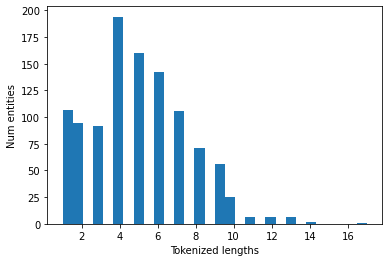

In [186]:
import matplotlib.pyplot as plt 

import numpy as np 

%matplotlib inline

# x = np.random.normal(size = 1000) 
x = lengths
plt.hist(x, bins=30) 

plt.ylabel('Num entities');
plt.xlabel('Tokenized lengths')

In [191]:
sp.encode('plays for')

[167, 10, 96]

In [104]:
len(uniq_ent_map)

1880592

In [143]:
def replaceEntities(line, aliases_dict):
    line = line.strip().split('\t')
    q = line[0]
    # sometimes no answer
    if len(line) > 1:
        answers= line[1].split('|')
    else:
        answers = []    
    lhs = q.split('[')[0]
    rhs = q.split(']')[1]
    head_id = q.split('[')[1].split(']')[0]
    if head_id in aliases_dict:
        head_text = aliases_dict[head_id]
    else:
        head_text = head_id
        print(head_text + ' not found')
    answers_text = []
    for a in answers:
        if a in aliases_dict:
            answers_text.append(aliases_dict[a])
        else:
            answers_text.append(a)
    answers_string = '|'.join(answers_text)
    
    out = '{lhs}[{head}]{rhs}\t{ans}'.format(
        lhs=lhs,
        rhs=rhs,
        head = head_text,
        ans = answers_string
    )
    return out
        
def readLines(fname):
    f = open(fname)
    lines = []
    for line in f:
        lines.append(line.rstrip())
    f.close()
    return lines

def writeLines(lines, fname):
    f = open(fname, 'w')
    for line in lines:
        f.write(line + '\n')
    f.close()

In [137]:
# need to make qa data as well, since entity aliases need to be used
# and not just entity ids as answers
fname = '/scratche/home/apoorv/EmbedKGQA/data/QA_data/WebQuestionsSP/qa_test_webqsp_fixed.txt'
questions = readLines(fname)


In [138]:
questions[1]

'what did james k polk do before he was president [m.042f1]\tm.02_bcst|m.04x_n9q|m.0cgqx'

In [144]:
lines_with_entities = [replaceEntities(q, uniq_ent_map) for q in questions]

m.02vkmj9 not found


In [145]:
len(lines_with_entities)

1639

In [146]:
lines_with_entities[:10]

['what does jamaican people speak [Jamaica 1]\tJamaican English|Jamaican Creole English Langua|Jamaican English',
 'what did james k polk do before he was president [James K. Polk]\tUnited States Representative|Governor of Tennessee|Speaker of the United States H',
 'who plays ken barlow in coronation street [Coronation Street]\tWilliam Roache',
 'where is jamarcus russell from [JaMarcus Russell]\tMobile 0',
 'where was george washington carver from [George Washington Carver]\tDiamond 8',
 'what else did ben franklin invent [Benjamin Franklin]\tLightning rod|Bifocals|Glass harmonica|Franklin stove',
 'who was richard nixon married to [Richard Nixon]\tPat Nixon',
 'who is governor of ohio 2011 [Ohio 2]\tJohn Kasich|Return J. Meigs, Jr.|Ted Strickland',
 'who was vice president after kennedy died [John F. Kennedy 0]\tLyndon B. Johnson 1',
 'where is the fukushima daiichi nuclear plant located [Fukushima Daiichi Nuclear Powe]\tJapan 1|Okuma']

In [148]:
fname = 'data/fbwq_half/qa_valid_1hop.txt'
writeLines(lines_with_entities, fname)